<a href="https://colab.research.google.com/github/Pbrillan/CEIA/blob/main/VPC2/TP3_VPC2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Ejercicio Práctico - Clase 3 VPC2 - 4Co2021

1) Realizar transfer learning a partir de alguna de las siguientes redes: vgg11, resnet18, convnext_tiny preentrenadas, y entrenar sobre el dataset CIFAR10 contenido en PyTorch. Que puede concluir al compararlos con los resultados obtenidos en el entrenamiento de la tarea 2?

2) Realice el entrenamiento de la misma red seleccionada en el punto 1, sin partir de pesos preentrenados en esta oportunidad y sin congelar capas. A que resultados llega y como los explica?


In [1]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torchvision
import torchsummary

!pip install torchmetrics
import torchmetrics

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 419 kB 4.6 MB/s 


In [2]:
from torchvision.datasets import CIFAR10

In [3]:
transform = torchvision.transforms.Compose(
    [torchvision.transforms.RandomHorizontalFlip(p=0.5),
     torchvision.transforms.RandomResizedCrop(size=(150, 150), scale=(0.7, 1.0)),
     #torchvision.transforms.ColorJitter(saturation=0.05, hue=0.05),
     #torchvision.transforms.RandomPerspective(p=0.25),
     #torchvision.transforms.RandomSolarize(p=0.5,threshold=0.5),
     #torchvision.transforms.RandomAutocontrast(p=0.5),
     #torchvision.transforms.RandomEqualize(p=0.5),
     torchvision.transforms.ToTensor(),
     torchvision.transforms.Resize(size=(150, 150)),
     torchvision.transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 32


train_set = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)

#train_size = int(len(train_data) * 0.8) # 80% training data
#valid_size = len(train_data) - train_size # 20% validation data
#train_set, valid_set = torch.utils.data.random_split(train_data, [train_size, valid_size])


valid_set = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)

train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size,
                                          shuffle=True, num_workers=2)
valid_loader = torch.utils.data.DataLoader(valid_set, batch_size=batch_size,
                                          shuffle=True, num_workers=2)



  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


#Con Transfer learning

In [4]:
vgg11_model = torchvision.models.vgg11(pretrained=True)

#vgg11_model.to("cuda")
#torchsummary.summary(vgg11_model, input_size=(3, 32, 32))
#vgg11_model.modules

Downloading: "https://download.pytorch.org/models/vgg11-8a719046.pth" to /root/.cache/torch/hub/checkpoints/vgg11-8a719046.pth


  0%|          | 0.00/507M [00:00<?, ?B/s]

In [5]:
for param in vgg11_model.parameters():
    param.requires_grad = False

In [6]:
last_layer_in_features = vgg11_model.classifier[-1].in_features
vgg11_model.classifier[-1] = torch.nn.Linear(in_features=last_layer_in_features, out_features=32)


In [7]:
optimizer_ft = torch.optim.Adam(vgg11_model.parameters(), lr=0.0001)
criterion = torch.nn.CrossEntropyLoss()

In [8]:
def train(model, criterion, optimizer, train_loader, valid_loader, epochs):

    accuracy_metric = torchmetrics.Accuracy()

    if torch.cuda.is_available():
        model.to("cuda")
        accuracy_metric.to("cuda")

    train_loss = []
    train_acc = []
    valid_loss = []
    valid_acc = []

    for epoch in range(epochs):

        # Pongo el modelo en modo entrenamiento
        model.train()

        epoch_train_loss = 0.0
        epoch_train_accuracy = 0.0

        for train_data, train_target in train_loader:
            
            if torch.cuda.is_available():
                train_data = train_data.to("cuda")
                train_target = train_target.to("cuda")
          

            optimizer.zero_grad()
            output = model(train_data)
            loss = criterion(output, train_target)
            epoch_train_loss += loss.item()
            loss.backward()
            optimizer.step()

            accuracy = accuracy_metric(output, train_target)
            epoch_train_accuracy += accuracy.item()

        epoch_train_loss = epoch_train_loss / len(train_loader)
        epoch_train_accuracy = epoch_train_accuracy / len(train_loader)
        train_loss.append(epoch_train_loss)
        train_acc.append(epoch_train_accuracy)

        # Pongo el modelo en modo testeo
        model.eval()

        epoch_valid_loss = 0.0
        epoch_valid_accuracy = 0.0

        for valid_data, valid_target in valid_loader:
            if torch.cuda.is_available():
                valid_data = valid_data.to("cuda")
                valid_target = valid_target.to("cuda")

            output = model(valid_data)
            epoch_valid_loss += criterion(output, valid_target).item()
            epoch_valid_accuracy += accuracy_metric(output, valid_target).item()
            
        epoch_valid_loss = epoch_valid_loss / len(valid_loader)
        epoch_valid_accuracy = epoch_valid_accuracy / len(valid_loader)
        valid_loss.append(epoch_valid_loss)
        valid_acc.append(epoch_valid_accuracy)

        print("Epoch: {}/{} - Train loss {:.6f} - Train Accuracy {:.6f} - Valid Loss {:.6f} - Valid Accuracy {:.6f}".format(
        epoch+1, epochs, epoch_train_loss, epoch_train_accuracy, epoch_valid_loss, epoch_valid_accuracy))

    history = {}
    history["train_loss"] = train_loss
    history["train_acc"] = train_acc
    history["valid_loss"] = valid_loss
    history["valid_acc"] = valid_acc

    return model, history

In [9]:
result_model, history = train(vgg11_model, criterion, optimizer_ft, train_loader, valid_loader, 30)

Epoch: 1/30 - Train loss 1.048905 - Train Accuracy 0.660349 - Valid Loss 0.778708 - Valid Accuracy 0.740415
Epoch: 2/30 - Train loss 0.785466 - Train Accuracy 0.726188 - Valid Loss 0.709119 - Valid Accuracy 0.756490
Epoch: 3/30 - Train loss 0.747702 - Train Accuracy 0.741383 - Valid Loss 0.683724 - Valid Accuracy 0.768271
Epoch: 4/30 - Train loss 0.725222 - Train Accuracy 0.746301 - Valid Loss 0.666733 - Valid Accuracy 0.770767
Epoch: 5/30 - Train loss 0.710464 - Train Accuracy 0.752599 - Valid Loss 0.655321 - Valid Accuracy 0.774760
Epoch: 6/30 - Train loss 0.702074 - Train Accuracy 0.753139 - Valid Loss 0.647018 - Valid Accuracy 0.777057
Epoch: 7/30 - Train loss 0.694162 - Train Accuracy 0.759697 - Valid Loss 0.635071 - Valid Accuracy 0.777855
Epoch: 8/30 - Train loss 0.691888 - Train Accuracy 0.757118 - Valid Loss 0.628335 - Valid Accuracy 0.788139
Epoch: 9/30 - Train loss 0.685152 - Train Accuracy 0.759557 - Valid Loss 0.627355 - Valid Accuracy 0.783846
Epoch: 10/30 - Train loss 0.

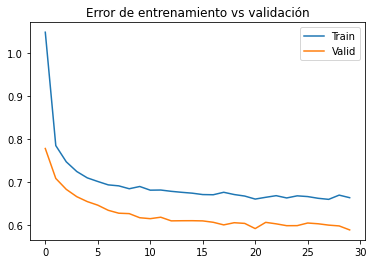

In [10]:
plt.plot(history["train_loss"])
plt.plot(history["valid_loss"])
plt.title("Error de entrenamiento vs validación")
plt.legend(['Train', 'Valid'])
plt.show()

#Sin Transfer learning

In [40]:
vgg11_model2 = torchvision.models.vgg11(pretrained=False)

In [41]:
last_layer_in_features2 = vgg11_model2.classifier[-1].in_features
vgg11_model2.classifier[-1] = torch.nn.Linear(in_features=last_layer_in_features2, out_features=32)

In [42]:
optimizer_ft2 = torch.optim.Adam(vgg11_model2.parameters(), lr=0.0001)
criterion2 = torch.nn.CrossEntropyLoss()


In [43]:
def train(model, criterion, optimizer, train_loader, valid_loader, epochs):

    accuracy_metric = torchmetrics.Accuracy()

    if torch.cuda.is_available():
        model.to("cuda")
        accuracy_metric.to("cuda")

    train_loss = []
    train_acc = []
    valid_loss = []
    valid_acc = []

    for epoch in range(epochs):

        # Pongo el modelo en modo entrenamiento
        model.train()

        epoch_train_loss = 0.0
        epoch_train_accuracy = 0.0

        for train_data, train_target in train_loader:
            
            if torch.cuda.is_available():
                train_data = train_data.to("cuda")
                train_target = train_target.to("cuda")
          

            optimizer.zero_grad()
            output = model(train_data)
            loss = criterion(output, train_target)
            epoch_train_loss += loss.item()
            loss.backward()
            optimizer.step()

            accuracy = accuracy_metric(output, train_target)
            epoch_train_accuracy += accuracy.item()

        epoch_train_loss = epoch_train_loss / len(train_loader)
        epoch_train_accuracy = epoch_train_accuracy / len(train_loader)
        train_loss.append(epoch_train_loss)
        train_acc.append(epoch_train_accuracy)

        # Pongo el modelo en modo testeo
        model.eval()

        epoch_valid_loss = 0.0
        epoch_valid_accuracy = 0.0

        for valid_data, valid_target in valid_loader:
            if torch.cuda.is_available():
                valid_data = valid_data.to("cuda")
                valid_target = valid_target.to("cuda")

            output = model(valid_data)
            epoch_valid_loss += criterion(output, valid_target).item()
            epoch_valid_accuracy += accuracy_metric(output, valid_target).item()
            
        epoch_valid_loss = epoch_valid_loss / len(valid_loader)
        epoch_valid_accuracy = epoch_valid_accuracy / len(valid_loader)
        valid_loss.append(epoch_valid_loss)
        valid_acc.append(epoch_valid_accuracy)

        print("Epoch: {}/{} - Train loss {:.6f} - Train Accuracy {:.6f} - Valid Loss {:.6f} - Valid Accuracy {:.6f}".format(
        epoch+1, epochs, epoch_train_loss, epoch_train_accuracy, epoch_valid_loss, epoch_valid_accuracy))

    history = {}
    history["train_loss"] = train_loss
    history["train_acc"] = train_acc
    history["valid_loss"] = valid_loss
    history["valid_acc"] = valid_acc

    return model, history

In [44]:
result_model2, history2 = train(vgg11_model2, criterion2, optimizer_ft2, train_loader, valid_loader, 30)

Epoch: 1/30 - Train loss 1.547604 - Train Accuracy 0.428323 - Valid Loss 1.255158 - Valid Accuracy 0.563399
Epoch: 2/30 - Train loss 0.972878 - Train Accuracy 0.657849 - Valid Loss 0.814917 - Valid Accuracy 0.715256
Epoch: 3/30 - Train loss 0.737280 - Train Accuracy 0.744022 - Valid Loss 0.690374 - Valid Accuracy 0.766673
Epoch: 4/30 - Train loss 0.611647 - Train Accuracy 0.789767 - Valid Loss 0.581835 - Valid Accuracy 0.800419
Epoch: 5/30 - Train loss 0.518912 - Train Accuracy 0.823257 - Valid Loss 0.539197 - Valid Accuracy 0.818490
Epoch: 6/30 - Train loss 0.459137 - Train Accuracy 0.841571 - Valid Loss 0.491914 - Valid Accuracy 0.832169
Epoch: 7/30 - Train loss 0.401273 - Train Accuracy 0.860825 - Valid Loss 0.487438 - Valid Accuracy 0.838558
Epoch: 8/30 - Train loss 0.360168 - Train Accuracy 0.876799 - Valid Loss 0.439141 - Valid Accuracy 0.851238
Epoch: 9/30 - Train loss 0.316098 - Train Accuracy 0.890995 - Valid Loss 0.455093 - Valid Accuracy 0.849740
Epoch: 10/30 - Train loss 0.

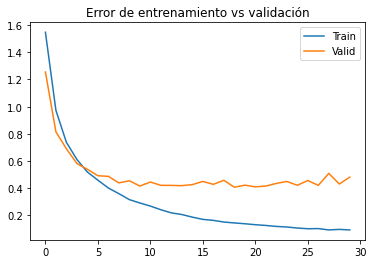

In [45]:
plt.plot(history2["train_loss"])
plt.plot(history2["valid_loss"])
plt.title("Error de entrenamiento vs validación")
plt.legend(['Train', 'Valid'])
plt.show()

#Con Transfer learning 2

In [ ]:
vgg11_model3 = torchvision.models.vgg11(pretrained=True)


#torchsummary.summary(vgg11_model, input_size=(3, 32, 32))
#vgg11_model.modules

In [ ]:
for param in vgg11_model3.parameters():
    param.requires_grad = False

In [ ]:
clayer_kernel_size = vgg11_model3.features[-3].kernel_size
clayer_stride = vgg11_model3.features[-3].stride
clayer_padding = vgg11_model3.features[-3].padding
clayer_in_channels = vgg11_model3.features[-3].in_channels
clayer_out_channels = vgg11_model3.features[-3].out_channels
vgg11_model3.features[-3] = torch.nn.Conv2d(in_channels=clayer_in_channels, out_channels=clayer_out_channels, kernel_size=clayer_kernel_size, stride=clayer_stride , padding=clayer_padding)


layer_in_features = vgg11_model3.classifier[-4].in_features
layer_out_features = vgg11_model3.classifier[-4].out_features
vgg11_model3.classifier[-4] = torch.nn.Linear(in_features=layer_in_features, out_features=layer_out_features)

layer_in_features = vgg11_model3.classifier[-7].in_features
layer_out_features = vgg11_model3.classifier[-7].out_features
vgg11_model3.classifier[-7] = torch.nn.Linear(in_features=layer_in_features, out_features=layer_out_features)

last_layer_in_features3 = vgg11_model3.classifier[-1].in_features
vgg11_model3.classifier[-1] = torch.nn.Linear(in_features=last_layer_in_features3, out_features=32)


In [ ]:
optimizer_ft = torch.optim.Adam(vgg11_model3.parameters(), lr=0.0001)
criterion = torch.nn.CrossEntropyLoss()

In [ ]:
def train(model, criterion, optimizer, train_loader, valid_loader, epochs):

    accuracy_metric = torchmetrics.Accuracy()

    if torch.cuda.is_available():
        model.to("cuda")
        accuracy_metric.to("cuda")

    train_loss = []
    train_acc = []
    valid_loss = []
    valid_acc = []

    for epoch in range(epochs):

        # Pongo el modelo en modo entrenamiento
        model.train()

        epoch_train_loss = 0.0
        epoch_train_accuracy = 0.0

        for train_data, train_target in train_loader:
            
            if torch.cuda.is_available():
                train_data = train_data.to("cuda")
                train_target = train_target.to("cuda")
          

            optimizer.zero_grad()
            output = model(train_data)
            loss = criterion(output, train_target)
            epoch_train_loss += loss.item()
            loss.backward()
            optimizer.step()

            accuracy = accuracy_metric(output, train_target)
            epoch_train_accuracy += accuracy.item()

        epoch_train_loss = epoch_train_loss / len(train_loader)
        epoch_train_accuracy = epoch_train_accuracy / len(train_loader)
        train_loss.append(epoch_train_loss)
        train_acc.append(epoch_train_accuracy)

        # Pongo el modelo en modo testeo
        model.eval()

        epoch_valid_loss = 0.0
        epoch_valid_accuracy = 0.0

        for valid_data, valid_target in valid_loader:
            if torch.cuda.is_available():
                valid_data = valid_data.to("cuda")
                valid_target = valid_target.to("cuda")

            output = model(valid_data)
            epoch_valid_loss += criterion(output, valid_target).item()
            epoch_valid_accuracy += accuracy_metric(output, valid_target).item()
            
        epoch_valid_loss = epoch_valid_loss / len(valid_loader)
        epoch_valid_accuracy = epoch_valid_accuracy / len(valid_loader)
        valid_loss.append(epoch_valid_loss)
        valid_acc.append(epoch_valid_accuracy)

        print("Epoch: {}/{} - Train loss {:.6f} - Train Accuracy {:.6f} - Valid Loss {:.6f} - Valid Accuracy {:.6f}".format(
        epoch+1, epochs, epoch_train_loss, epoch_train_accuracy, epoch_valid_loss, epoch_valid_accuracy))

    history = {}
    history["train_loss"] = train_loss
    history["train_acc"] = train_acc
    history["valid_loss"] = valid_loss
    history["valid_acc"] = valid_acc

    return model, history

In [ ]:
result_model, history = train(vgg11_model3, criterion, optimizer_ft, train_loader, valid_loader, 10)

Epoch: 1/10 - Train loss 0.659956 - Train Accuracy 0.772653 - Valid Loss 0.469078 - Valid Accuracy 0.837660
Epoch: 2/10 - Train loss 0.397311 - Train Accuracy 0.864583 - Valid Loss 0.381951 - Valid Accuracy 0.870208
Epoch: 3/10 - Train loss 0.319730 - Train Accuracy 0.891115 - Valid Loss 0.386235 - Valid Accuracy 0.877396
Epoch: 4/10 - Train loss 0.271620 - Train Accuracy 0.907889 - Valid Loss 0.415357 - Valid Accuracy 0.866913
Epoch: 5/10 - Train loss 0.236443 - Train Accuracy 0.919166 - Valid Loss 0.368166 - Valid Accuracy 0.882588
Epoch: 6/10 - Train loss 0.213620 - Train Accuracy 0.926384 - Valid Loss 0.359440 - Valid Accuracy 0.891773
Epoch: 7/10 - Train loss 0.185126 - Train Accuracy 0.937380 - Valid Loss 0.374449 - Valid Accuracy 0.888978
Epoch: 8/10 - Train loss 0.172335 - Train Accuracy 0.941319 - Valid Loss 0.356462 - Valid Accuracy 0.893570
Epoch: 9/10 - Train loss 0.154450 - Train Accuracy 0.948377 - Valid Loss 0.368775 - Valid Accuracy 0.895767
Epoch: 10/10 - Train loss 0.

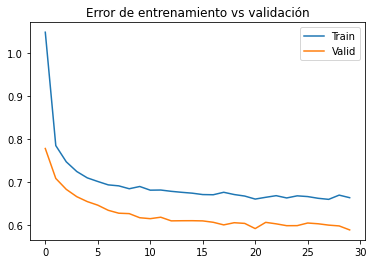

In [ ]:
plt.plot(history["train_loss"])
plt.plot(history["valid_loss"])
plt.title("Error de entrenamiento vs validación")
plt.legend(['Train', 'Valid'])
plt.show()

#Conclusiones

Primero se entreno un modelo con transfer learning y solo la ultima capa sin congelar
Posteriormente se entreno el mismo modelo sin transfer learning

Se esperaba que con el modelo pre entrenado se desempeñe mejor que el modelo sin transfer learning pero por contrario encontramos que el modelo sin tl aprendio mejor y mas rapido


Por ultimo se entreno el mismo modelo con transfer learning y mas capas sin congelar donde se obtuvo mejor desempeño que en el modelo sin transfer learning en muchas menos epocas de entrenamiento



Como conclusion general en el primer modelo por tener solo una capa actualizando parametros no alcanza para cambiar las caracteristicas del entrenamiento original por las nuevas caracteristicas que se quieren entrenar al aumentar el numero de capas sobre las que se entrena se le permite a la red aprender las caracteristicas mas abstractas del problema manteniendo las primeras capas pre entrenadas para que expliquen las caracteristicas de mas bajo nivel.